In [43]:
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
from datetime import datetime
import os
import shutil
import argparse
import time
import json
from collections import defaultdict
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.parallel import DistributedDataParallel
from tqdm import tqdm
from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import show_slices

from celluloid import Camera
from IPython.core.display import HTML
from train import DiceScoreBinary, CatBrainMaskLoader, create_datesets

In [5]:
MAKE_LOGS = False
SAVE_MODEL = False
DEVICE = 3

In [6]:
logdir = 'logs/v2v_whole_s128_bs1_trim@22.11.2021-18:37:14/'

In [7]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

device = torch.device(DEVICE)

writer = None
model = V2VModel(config).to(device)
print('Model created!')

# setting datasets
train_dataset, val_dataset = create_datesets(config)
train_dataloader = DataLoader(train_dataset, batch_size=config.opt.train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.opt.val_batch_size, shuffle=False)

# setting model stuff
criterion = {
    "CE": torch.nn.CrossEntropyLoss(),
    "BCE": torch.nn.BCELoss(),
    "FDice": None
}[config.opt.criterion]

model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights.pth'))
model.load_state_dict(model_dict['model_state'])

Model created!


In [9]:
len(val_dataloader)

8

In [10]:
len(val_dataset)

8

In [11]:
len(train_dataloader)

69

In [12]:
brain_tensors = []
predicted_masks = []
real_masks = []
dices = []

iterator = enumerate(val_dataloader)

for iter_i, (brain_tensor, _,mask_tensor) in tqdm(iterator):
    # prepare
    brain_tensor = brain_tensor # [bs,1,ps,ps,ps]
    mask_tensor = mask_tensor # [bs,ps,ps,ps]

    if config.interpolate:
        brain_tensor = F.interpolate(brain_tensor, config.interpolation_size).to(device)
        mask_tensor = F.interpolate(mask_tensor, config.interpolation_size).to(device) # unsqueeze channel
    else:
        brain_tensor = brain_tensor.to(device)
        mask_tensor = mask_tensor.to(device)

    # forward pass
    mask_tensor_predicted = model(brain_tensor) # [bs,2,ps,ps,ps]
    
    dice_score = DiceScoreBinary(mask_tensor_predicted.detach().cpu(), mask_tensor.detach().cpu())
    dices.append(dice_score.item())
    
    assert brain_tensor.shape[0] == 1
    mask_tensor_sample = mask_tensor.detach().cpu().numpy()[0,0] 
    brain_tensor_sample = brain_tensor.detach().cpu().numpy()[0,0]
    mask_tensor_predicted_sample = mask_tensor_predicted.detach().cpu().numpy()[0,0]
    
    # crucial!
    del mask_tensor_predicted, brain_tensor, mask_tensor
    
    brain_tensors.append(brain_tensor_sample)
    predicted_masks.append(mask_tensor_predicted_sample)
    real_masks.append(mask_tensor_sample)
    
    torch.cuda.empty_cache()

8it [00:10,  1.35s/it]


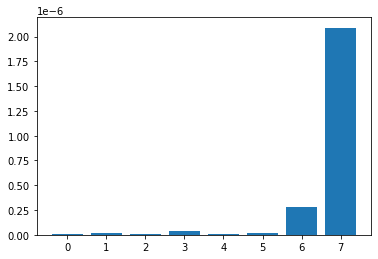

In [13]:
plt.bar(np.arange(len(dices)), dices)
plt.show()

In [14]:
def video_comparison(brain_tensor, mask_tensor_real, mask_tensor_pred, n_slides=64):
    
    fig, ax = plt.subplots(1,2)
    X_max, Y_max, Z_max = brain_tensor.shape
    camera = Camera(fig)
    
    for i in range(n_slides):
        
        y_slice_pos = (Y_max//(n_slides+2))*(i+1)
        
        brain_tensor_slice = brain_tensor[:,y_slice_pos,:]
        ax[0].imshow(brain_tensor_slice, 'gray')
        ax[1].imshow(brain_tensor_slice, 'gray')
        
        mask_tensor_real_slice = mask_tensor_real[:,y_slice_pos,:]
        mask_tensor_pred_slice = mask_tensor_pred[:,y_slice_pos,:]
        
        ax[0].imshow(mask_tensor_real_slice, 'jet', interpolation='none', alpha=0.7)
        ax[1].imshow(mask_tensor_pred_slice, 'jet', interpolation='none', alpha=0.7)
        
        ax[0].set_title('GT')
        ax[1].set_title('Pred')
        
        camera.snap()
        
    return camera   
    

In [30]:
brain_tensors[0].shape

(128, 128, 128)

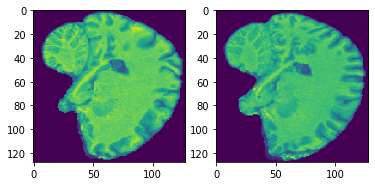

In [42]:
d = 20
plt.figure()
ax = plt.subplot(121)
ax.imshow(brain_tensors[0][64-d,:,:])
ax = plt.subplot(122)
ax.imshow(brain_tensors[0][64+d,:,:])
plt.show()

In [ ]:
plt.imshow(brain_tensors[0][60,:,:])

In [15]:
# l_max = [for rm in real_masks]

In [16]:
# brain_tensors[0].shape

In [17]:
# np.array(real_masks).sum()

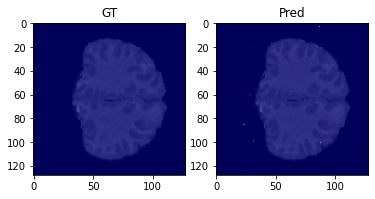

In [18]:
ind = 2 #np.argmin(dices)
plt.ioff()
camera = video_comparison(brain_tensors[ind], 
                          real_masks[ind],
                          predicted_masks[ind], 
                          n_slides=100)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation